In [9]:

import numpy as np
import torch
import random
from collections import deque
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import datetime
import pickle
import math
import matplotlib.pyplot as plt

In [10]:
def plot_learning_curve(x, scores, figure_file):
    running_avg_score = np.zeros(len(scores))
    for i in range(len(running_avg_score)):
        running_avg_score[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg_score, '-b')
    plt.title('Média móvel das últimas 100 pontuações')
    plt.savefig(figure_file)

def plot_success_curve(x, successes, figure_file):
    running_success_rate = np.zeros(len(successes))
    for i in range(len(running_success_rate)):
        running_success_rate[i] = np.mean(successes[max(0, i-50):(i+1)])
    plt.plot(x, running_success_rate, '-g')
    plt.title('Taxa de sucesso dos últimos 50 episódios')
    plt.savefig(figure_file)

def plot_step_curve(x, steps, figure_file):
    running_step_avg = np.zeros(len(steps))
    for i in range(len(running_step_avg)):
        running_step_avg[i] = np.mean(steps[max(0, i-200):(i+1)])
    plt.plot(x, running_step_avg, '-g')
    plt.title('Média móvel da duração dos últimos 200 episódios')
    plt.savefig(figure_file)

In [11]:
import mujoco
import mediapy as media
import random

class MujocoEnv1_0:
    def __init__(self):
        self.high = 1
        self.low = -1
        self.state_dim = 8
        self.action_dim = 9
        self.name = "MujocoEnv-v1-0"
        self.theta1 = 0
        self.theta2 = 0
        self.model = mujoco.MjModel.from_xml_path("/home/kuka/Documents/ic/codigos_bons/sim_env/environmentS.xml")
        self.agent = Agent(self.state_dim,self.action_dim)

        self.data = mujoco.MjData(self.model)
        self.renderer = None
        self.renderer = mujoco.Renderer(self.model, 240, 360)
        self.framerate = 24
        self.frames = []
        mujoco.mj_forward(self.model, self.data)
        self.data.ctrl[6] = 0.05
        self.dt = 0.1

    def reset(self):
        mujoco.mj_resetData(self.model, self.data)
        mujoco.mj_forward(self.model, self.data)
        self.frames = []
        self.data.ctrl[6] = 0.05
        self.renderer = None
        self.renderer = mujoco.Renderer(self.model, 240, 360)
        self.data.qpos[0:3] = [-1,-1,2.5]
        self.data.qvel[0:3] = [2.75,1,3]
        theta1 = self.data.qpos[7].copy()
        theta2 = self.data.qpos[8].copy()
        x0,y0,z0 = self.data.qpos[0:3].copy()
        vx0,vy0,vz0 = self.data.qvel[0:3].copy()
        return (theta1,theta2,x0,y0,z0,vx0,vy0,vz0)
    
    def calculaTarget(self):
        x0,y0,z0 = self.data.qpos[0:3].copy()
        vx0,vy0,vz0 = self.data.qvel[0:3].copy()
        tempo_queda = (vz0+np.sqrt(np.abs(vz0**2+2*9.8*(z0-0.589))))/9.8
        targetx = x0 + tempo_queda*vx0
        targety = y0 + tempo_queda*vy0
        return targetx, targety
    def calculaDistanciaTarget(self, targetx, targety):
        return np.sqrt((self.data.geom_xpos[9,0].copy()-targetx)**2 + (self.data.geom_xpos[9,1].copy()-targety)**2)
    def calculaDistancia(self):
        xo,yo,zo = self.data.geom_xpos[1].copy()
        xc,yc,zc = self.data.geom_xpos[9].copy()
        return np.sqrt((xo-xc)**2+(yo-yc)**2+(zo-zc)**2)

    def step(self, action):
        action = self.agent.take_action(action)
        done = False
        theta1 = self.data.qpos[7].copy()
        theta2 = self.data.qpos[8].copy()
        omega1 = 3*action[0]
        omega2 = 3*action[1]
        if theta1 < -3.2:
            omega1 = max(omega1,0)
        if theta1 > 3.2:
            omega1 = min(omega1,0)
        if theta2 > -0.1:
            omega2 = min(omega2,0)
        if theta2 < -1.2:
            omega2 = max(omega2,0)
        self.data.ctrl[0:6] = [omega1,omega2/2,-omega2,0,omega2/2,0]
        nextt = self.data.time + self.dt
        while self.data.time < nextt:
            mujoco.mj_step(self.model, self.data)
        distancia = self.calculaDistanciaTarget(*self.calculaTarget())
        reward = -5*distancia
        if self.data.time > 3 or self.data.qpos[2] < 0.2:
            done = True
        if self.calculaDistancia() < 0.05:
            done = True
            reward += 200
            print('success')
        theta1 = self.data.qpos[7].copy()
        theta2 = self.data.qpos[8].copy()
        x0,y0,z0 = self.data.qpos[0:3].copy()
        vx0,vy0,vz0 = self.data.qvel[0:3].copy()
        return (theta1,theta2,x0,y0,z0,vx0,vy0,vz0), reward, done

    def rstep(self, action):
        action = self.agent.take_action(action)
        done = False
        theta1 = self.data.qpos[7].copy()
        theta2 = self.data.qpos[8].copy()
        omega1 = 3*action[0]
        omega2 = 3*action[1]
        if theta1 < -3.2:
            omega1 = max(omega1,0)
        if theta1 > 3.2:
            omega1 = min(omega1,0)
        if theta2 > -0.1:
            omega2 = min(omega2,0)
        if theta2 < -1.2:
            omega2 = max(omega2,0)
        self.data.ctrl[0:6] = [omega1,omega2/2,-omega2,0,omega2/2,0]
        nextt = self.data.time + self.dt
        while self.data.time < nextt:
            mujoco.mj_step(self.model, self.data)
            if len(self.frames) < self.data.time * self.framerate:
                self.renderer.update_scene(self.data,camera='depth_camera0')
                pixels = self.renderer.render()
                self.frames.append(pixels)
        distancia = self.calculaDistanciaTarget(*self.calculaTarget())
        reward = -10*distancia**2
        if self.data.time > 3 or self.data.qpos[2] < 0.2:
            done = True
        if self.calculaDistancia() < 0.05:
            done = True
            reward += 200
            print('success')
        theta1 = self.data.qpos[7].copy()
        theta2 = self.data.qpos[8].copy()
        x0,y0,z0 = self.data.qpos[0:3].copy()
        vx0,vy0,vz0 = self.data.qvel[0:3].copy()
        return (theta1,theta2,x0,y0,z0,vx0,vy0,vz0), reward, done

class MujocoEnv1_1:
    def __init__(self):
        self.high = 1
        self.low = -1
        self.state_dim = 4
        self.action_dim = 9
        self.name = "MujocoEnv-v1-1"
        self.theta1 = 0
        self.theta2 = 0
        self.x0 = 0
        self.y0 = 0
        self.z0 = 0
        self.vx0 = 0
        self.vy0 = 0
        self.vz0 = 0
        self.targetx = 0
        self.targety = 0
        self.model = mujoco.MjModel.from_xml_path("/home/kuka/Documents/ic/codigos_bons/sim_env/environmentS.xml")
        self.agent = Agent(self.state_dim,self.action_dim)

        self.data = mujoco.MjData(self.model)
        self.renderer = None
        self.renderer = mujoco.Renderer(self.model, 240, 360)
        self.framerate = 24
        self.frames = []
        mujoco.mj_forward(self.model, self.data)
        self.data.ctrl[6] = 0.05
        self.dt = 0.1

    def calculaTarget(self):
        tempo_queda = (self.vz0+np.sqrt(self.vz0**2+2*9.8*(self.z0-0.589)))/9.8
        self.targetx = self.x0 + tempo_queda*self.vx0
        self.targety = self.y0 + tempo_queda*self.vy0

    def calculaDistanciaTarget(self):
        return np.sqrt((self.data.geom_xpos[9,0].copy()-self.targetx)**2 + (self.data.geom_xpos[9,1].copy()-self.targety)**2)

    def getGoodBola(self):
        d=0
        while d < 1 or d > 1.8:
            self.x0 = random.uniform(-1.5,1.5)
            self.y0 = random.uniform(-1.5,1.5)
            self.z0 = random.uniform(2,3)
            self.vx0 = random.uniform(-2,2)
            self.vy0 = random.uniform(-2,2)
            self.vz0 = random.uniform(2,3)
            self.calculaTarget()
            d = np.sqrt(self.targetx**2+self.targety**2)

    def reset(self):
        mujoco.mj_resetData(self.model, self.data)
        mujoco.mj_forward(self.model, self.data)
        self.frames = []
        self.data.ctrl[6] = 0.3
        self.renderer = None
        self.renderer = mujoco.Renderer(self.model, 240, 360)

        self.getGoodBola()
        self.calculaTarget()
        xc,yc,zc = self.data.geom_xpos[9].copy()
        self.data.qpos[0:3] = [self.x0,self.y0,self.z0]
        self.data.qvel[0:3] = [self.vx0,self.vy0,self.vz0]
        mujoco.mj_forward(self.model, self.data)
        return (xc,yc,self.targetx,self.targety)

    def step(self, action):
        action = self.agent.take_action(action)
        done = False
        theta1 = self.data.qpos[7].copy()
        theta2 = self.data.qpos[8].copy()
        omega1 = 3*action[0]
        omega2 = 3*action[1]
        if theta1 < -3.2:
            omega1 = max(omega1,0)
        if theta1 > 3.2:
            omega1 = min(omega1,0)
        if theta2 > -0.1:
            omega2 = min(omega2,0)
        if theta2 < -1.2:
            omega2 = max(omega2,0)
        self.data.ctrl[0:6] = [omega1,omega2/2,-omega2,0,omega2/2,0]
        nextt = self.data.time + self.dt
        while self.data.time < nextt:
            mujoco.mj_step(self.model, self.data)
        distancia = self.calculaDistanciaTarget()
        reward = -2*distancia-2
        if self.data.time > 5:
            done = True
        if distancia < 0.05:
            done = True
            reward += 200
            print('success')
        xc,yc,zc = self.data.geom_xpos[9].copy()
        return (xc,yc,self.targetx,self.targety), reward, done

    def rstep(self, action):
        action = self.agent.take_action(action)
        done = False
        theta1 = self.data.qpos[7].copy()
        theta2 = self.data.qpos[8].copy()
        omega1 = 3*action[0]
        omega2 = 3*action[1]
        if theta1 < -3.2:
            omega1 = max(omega1,0)
        if theta1 > 3.2:
            omega1 = min(omega1,0)
        if theta2 > -0.1:
            omega2 = min(omega2,0)
        if theta2 < -1.2:
            omega2 = max(omega2,0)
        self.data.ctrl[0:6] = [omega1,omega2/2,-omega2,0,omega2/2,0]
        nextt = self.data.time + self.dt
        while self.data.time < nextt:
            mujoco.mj_step(self.model, self.data)
            if len(self.frames) < self.data.time * self.framerate:
                self.renderer.update_scene(self.data,camera='depth_camera0')
                pixels = self.renderer.render()
                self.frames.append(pixels)
        distancia = self.calculaDistanciaTarget()
        reward = -2*distancia-2
        if self.data.time > 5:
            done = True
        if distancia < 0.05:
            done = True
            reward += 200
            print('success')
            self.data.ctrl[0:6] = [0,0,0,0,0,0]
            while self.data.time < 5:
                mujoco.mj_step(self.model, self.data)
                if len(self.frames) < self.data.time * self.framerate:
                    self.renderer.update_scene(self.data,camera='depth_camera0')
                    pixels = self.renderer.render()
                    self.frames.append(pixels)
        xc,yc,zc = self.data.geom_xpos[9].copy()
        return (xc,yc,self.targetx,self.targety), reward, done

class MujocoEnv1_2:
    def __init__(self):
        self.high = 1
        self.low = -1
        self.state_dim = 4
        self.action_dim = 9
        self.name = "MujocoEnv-v1-2"
        self.theta1 = 0
        self.theta2 = 0
        self.x0 = 0
        self.y0 = 0
        self.z0 = 0
        self.vx0 = 0
        self.vy0 = 0
        self.vz0 = 0
        self.targetx = 0
        self.targety = 0
        self.model = mujoco.MjModel.from_xml_path("/home/kuka/Documents/ic/codigos_bons/sim_env/environmentS.xml")
        self.agent = Agent(self.state_dim,self.action_dim)

        self.data = mujoco.MjData(self.model)
        self.renderer = None
        self.renderer = mujoco.Renderer(self.model, 240, 360)
        self.framerate = 24
        self.frames = []
        mujoco.mj_forward(self.model, self.data)
        self.data.ctrl[6] = 0.05
        self.dt = 0.1

    def calculaTarget(self):
        tempo_queda = (self.vz0+np.sqrt(self.vz0**2+2*9.8*(self.z0-0.589)))/9.8
        self.targetx = self.x0 + tempo_queda*self.vx0
        self.targety = self.y0 + tempo_queda*self.vy0

    def calculaDistanciaTarget(self):
        return np.sqrt((self.data.geom_xpos[9,0].copy()-self.targetx)**2 + (self.data.geom_xpos[9,1].copy()-self.targety)**2)

    def getGoodBola(self):
        d=0
        while d < 1 or d > 1.8:
            self.x0 = random.uniform(-1.5,1.5)
            self.y0 = random.uniform(-1.5,1.5)
            self.z0 = random.uniform(2,3)
            self.vx0 = random.uniform(-2,2)
            self.vy0 = random.uniform(-2,2)
            self.vz0 = random.uniform(2,3)
            self.calculaTarget()
            d = np.sqrt(self.targetx**2+self.targety**2)

    def reset(self):
        mujoco.mj_resetData(self.model, self.data)
        mujoco.mj_forward(self.model, self.data)
        self.frames = []
        self.data.ctrl[6] = 0.3
        self.renderer = None
        self.renderer = mujoco.Renderer(self.model, 240, 360)

        self.getGoodBola()
        self.calculaTarget()
        xc,yc,zc = self.data.geom_xpos[9].copy()
        self.data.qpos[0:3] = [self.x0,self.y0,self.z0]
        self.data.qvel[0:3] = [self.vx0,self.vy0,self.vz0]
        mujoco.mj_forward(self.model, self.data)
        self.theta1 = self.data.qpos[7]
        self.theta2 = self.data.qpos[8]
        return (self.theta1,self.theta2,self.targetx,self.targety)

    def step(self, action):
        action = self.agent.take_action(action)
        done = False
        theta1 = self.data.qpos[7].copy()
        theta2 = self.data.qpos[8].copy()
        omega1 = 3*action[0]
        omega2 = 3*action[1]
        if theta1 < -3.2:
            omega1 = max(omega1,0)
        if theta1 > 3.2:
            omega1 = min(omega1,0)
        if theta2 > -0.1:
            omega2 = min(omega2,0)
        if theta2 < -1.2:
            omega2 = max(omega2,0)
        self.data.ctrl[0:6] = [omega1,omega2/2,-omega2,0,omega2/2,0]
        nextt = self.data.time + self.dt
        while self.data.time < nextt:
            mujoco.mj_step(self.model, self.data)
        distancia = self.calculaDistanciaTarget()
        reward = -2*distancia-2
        if self.data.time > 5:
            done = True
        if distancia < 0.05:
            done = True
            reward += 200
            print('success')
        self.theta1 = self.data.qpos[7]
        self.theta2 = self.data.qpos[8]
        return (self.theta1,self.theta2,self.targetx,self.targety), reward, done

    def rstep(self, action):
        action = self.agent.take_action(action)
        done = False
        theta1 = self.data.qpos[7].copy()
        theta2 = self.data.qpos[8].copy()
        omega1 = 3*action[0]
        omega2 = 3*action[1]
        if theta1 < -3.2:
            omega1 = max(omega1,0)
        if theta1 > 3.2:
            omega1 = min(omega1,0)
        if theta2 > -0.1:
            omega2 = min(omega2,0)
        if theta2 < -1.2:
            omega2 = max(omega2,0)
        self.data.ctrl[0:6] = [omega1,omega2/2,-omega2,0,omega2/2,0]
        nextt = self.data.time + self.dt
        while self.data.time < nextt:
            mujoco.mj_step(self.model, self.data)
            if len(self.frames) < self.data.time * self.framerate:
                self.renderer.update_scene(self.data,camera='depth_camera0')
                pixels = self.renderer.render()
                self.frames.append(pixels)
        distancia = self.calculaDistanciaTarget()
        reward = -2*distancia-2
        if self.data.time > 5:
            done = True
        if distancia < 0.05:
            done = True
            reward += 200
            print('success')
            self.data.ctrl[0:6] = [0,0,0,0,0,0]
            while self.data.time < 5:
                mujoco.mj_step(self.model, self.data)
                if len(self.frames) < self.data.time * self.framerate:
                    self.renderer.update_scene(self.data,camera='depth_camera0')
                    pixels = self.renderer.render()
                    self.frames.append(pixels)
        self.theta1 = self.data.qpos[7]
        self.theta2 = self.data.qpos[8]
        return (self.theta1,self.theta2,self.targetx,self.targety), reward, done

class MujocoEnv0_0:
    def __init__(self):
        self.high = 1
        self.low = -1
        self.state_dim = 4
        self.action_dim = 9
        self.name = "MujocoEnv-v0-0"
        self.theta1 = 0
        self.theta2 = 0
        self.targetx = 0
        self.targety = 0
        self.model = mujoco.MjModel.from_xml_path("/home/kuka/Documents/ic/codigos_bons/sim_env/environmentS.xml")
        self.agent = Agent(self.state_dim,self.action_dim)

        self.data = mujoco.MjData(self.model)
        self.renderer = None
        self.renderer = mujoco.Renderer(self.model, 240, 360)
        self.framerate = 24
        self.frames = []
        mujoco.mj_forward(self.model, self.data)
        self.data.ctrl[6] = 0.05
        self.dt = 0.1

    def reset(self):
        mujoco.mj_resetData(self.model, self.data)
        mujoco.mj_forward(self.model, self.data)
        self.frames = []
        self.data.ctrl[6] = 0.05
        self.renderer = None
        self.renderer = mujoco.Renderer(self.model, 240, 360)
        xc,yc,zc = self.data.geom_xpos[9].copy()
        ang = random.uniform(-np.pi,np.pi)
        r = random.uniform(1,1.7)
        self.targetx = r*np.sin(ang)
        self.targety = r*np.cos(ang)
        return (xc,yc,self.targetx,self.targety)
    
    def calculaDistanciaTarget(self, targetx, targety):
        return np.sqrt((self.data.geom_xpos[9,0].copy()-targetx)**2 + (self.data.geom_xpos[9,1].copy()-targety)**2)
    
    def step(self, action):
        action = self.agent.take_action(action)
        done = False
        theta1 = self.data.qpos[7].copy()
        theta2 = self.data.qpos[8].copy()
        omega1 = 3*action[0]
        omega2 = 3*action[1]
        if theta1 < -3.2:
            omega1 = max(omega1,0)
        if theta1 > 3.2:
            omega1 = min(omega1,0)
        if theta2 > -0.1:
            omega2 = min(omega2,0)
        if theta2 < -1.2:
            omega2 = max(omega2,0)
        self.data.ctrl[0:6] = [omega1,omega2/2,-omega2,0,omega2/2,0]
        nextt = self.data.time + self.dt
        while self.data.time < nextt:
            mujoco.mj_step(self.model, self.data)
        distancia = self.calculaDistanciaTarget(self.targetx,self.targety)
        reward = -2*distancia -2
        if self.data.time > 5:
            done = True
        if distancia < 0.15:
            done = True
            reward += 200
            print('success')
        xc,yc,zc = self.data.geom_xpos[9].copy()
        return (xc,yc,self.targetx,self.targety), reward, done

    def rstep(self, action):
        action = self.agent.take_action(action)
        done = False
        theta1 = self.data.qpos[7].copy()
        theta2 = self.data.qpos[8].copy()
        omega1 = 3*action[0]
        omega2 = 3*action[1]
        if theta1 < -3.2:
            omega1 = max(omega1,0)
        if theta1 > 3.2:
            omega1 = min(omega1,0)
        if theta2 > -0.1:
            omega2 = min(omega2,0)
        if theta2 < -1.2:
            omega2 = max(omega2,0)
        self.data.ctrl[0:6] = [omega1,omega2/2,-omega2,0,omega2/2,0]
        nextt = self.data.time + self.dt
        while self.data.time < nextt:
            mujoco.mj_step(self.model, self.data)
            if len(self.frames) < self.data.time * self.framerate:
                self.renderer.update_scene(self.data,camera='depth_camera0')
                pixels = self.renderer.render()
                self.frames.append(pixels)
        distancia = self.calculaDistanciaTarget(self.targetx,self.targety)
        reward = -2*distancia -2
        if self.data.time > 5:
            done = True
        if distancia < 0.15:
            done = True
            reward += 200
            print('success')
        xc,yc,zc = self.data.geom_xpos[9].copy()
        return (xc,yc,self.targetx,self.targety), reward, done

class MujocoEnv2_0:
    def __init__(self):
        self.high = 1
        self.low = -1
        self.state_dim = 8
        self.action_dim = 9
        self.name = "MujocoEnv-v2-0"
        self.theta1 = 0
        self.theta2 = 0
        self.x0 = 0
        self.y0 = 0
        self.z0 = 0
        self.vx0 = 0
        self.vy0 = 0
        self.vz0 = 0
        self.targetx = 0
        self.targety = 0
        
        self.model = mujoco.MjModel.from_xml_path("/home/kuka/Documents/ic/codigos_bons/sim_env/environmentS.xml")
        self.agent = Agent(self.state_dim,self.action_dim)

        self.data = mujoco.MjData(self.model)
        print(self.data)
        self.renderer = None
        self.renderer = mujoco.Renderer(self.model, 240, 360)
        self.framerate = 24
        self.frames = []
        mujoco.mj_forward(self.model, self.data)
        self.data.ctrl[6] = 0.05
        self.dt = 0.1
        self.tfin = 0

    def calculaTarget(self):
        tempo_queda = (self.vz0+np.sqrt(self.vz0**2+2*9.8*(self.z0-0.589)))/9.8
        self.targetx = self.x0 + tempo_queda*self.vx0
        self.targety = self.y0 + tempo_queda*self.vy0

    def calculaDistanciaTarget(self):
        return np.sqrt((self.data.geom_xpos[9,0].copy()-self.targetx)**2 + (self.data.geom_xpos[9,1].copy()-self.targety)**2)

    def getGoodBola(self):
        d=0
        while d < 1 or d > 1.8:
            self.x0 = random.uniform(-1.5,1.5)
            self.y0 = random.uniform(-1.5,1.5)
            self.z0 = random.uniform(2,3)
            self.vx0 = random.uniform(-2,2)
            self.vy0 = random.uniform(-2,2)
            self.vz0 = random.uniform(2,3)
            self.calculaTarget()
            d = np.sqrt(self.targetx**2+self.targety**2)

    def reset(self):
        mujoco.mj_resetData(self.model, self.data)
        mujoco.mj_forward(self.model, self.data)
        self.frames = []
        self.data.ctrl[6] = 0.3
        self.renderer = None
        self.renderer = mujoco.Renderer(self.model, 240, 360)
        self.tfin = 0
        self.getGoodBola()
        self.calculaTarget()
        xc,yc,zc = self.data.geom_xpos[9].copy()
        self.data.qpos[0:3] = [self.x0,self.y0,self.z0]
        self.data.qvel[0:3] = [self.vx0,self.vy0,self.vz0]
        mujoco.mj_forward(self.model, self.data)
        self.theta1 = self.data.qpos[7]
        self.theta2 = self.data.qpos[8]
        return (self.theta1,self.theta2,self.x0,self.y0,self.z0,self.vx0,self.vy0,self.vz0)

    def step(self, action):
        action = self.agent.take_action(action)
        done = False
        theta1 = self.data.qpos[7].copy()
        theta2 = self.data.qpos[8].copy()
        omega1 = 3*action[0]
        omega2 = 3*action[1]
        if theta1 < -3.2:
            omega1 = max(omega1,0)
        if theta1 > 3.2:
            omega1 = min(omega1,0)
        if theta2 > -0.1:
            omega2 = min(omega2,0)
        if theta2 < -1.2:
            omega2 = max(omega2,0)
        self.data.ctrl[0:6] = [omega1,omega2/2,-omega2,0,omega2/2,0]
        nextt = self.data.time + self.dt
        while self.data.time < nextt:
            mujoco.mj_step(self.model, self.data)
        distancia = self.calculaDistanciaTarget()
        reward = -2*distancia-2-distancia**2
        if self.data.time > 5:
            done = True
            self.tfin = self.data.time
        if distancia < 0.05:
            done = True
            reward += 200
            print('success')
            self.tfin = self.data.time
        self.theta1 = self.data.qpos[7]
        self.theta2 = self.data.qpos[8]
        return (self.theta1,self.theta2,self.x0,self.y0,self.z0,self.vx0,self.vy0,self.vz0), reward, done

    def rstep(self, action):
        action = self.agent.take_action(action)
        done = False
        theta1 = self.data.qpos[7].copy()
        theta2 = self.data.qpos[8].copy()
        omega1 = 3*action[0]
        omega2 = 3*action[1]
        if theta1 < -3.2:
            omega1 = max(omega1,0)
        if theta1 > 3.2:
            omega1 = min(omega1,0)
        if theta2 > -0.1:
            omega2 = min(omega2,0)
        if theta2 < -1.2:
            omega2 = max(omega2,0)
        self.data.ctrl[0:6] = [omega1,omega2/2,-omega2,0,omega2/2,0]
        nextt = self.data.time + self.dt
        while self.data.time < nextt:
            mujoco.mj_step(self.model, self.data)
            if len(self.frames) < self.data.time * self.framerate:
                self.renderer.update_scene(self.data,camera='depth_camera0')
                pixels = self.renderer.render()
                self.frames.append(pixels)
        distancia = self.calculaDistanciaTarget()
        reward = -2*distancia-2-distancia**2
        if self.data.time > 5:
            done = True
            self.tfin = self.data.time
        if distancia < 0.05:
            done = True
            self.tfin = self.data.time
            reward += 200
            print('success')
            self.data.ctrl[0:6] = [0,0,0,0,0,0]
            while self.data.time < 5:
                mujoco.mj_step(self.model, self.data)
                if len(self.frames) < self.data.time * self.framerate:
                    self.renderer.update_scene(self.data,camera='depth_camera0')
                    pixels = self.renderer.render()
                    self.frames.append(pixels)
        self.theta1 = self.data.qpos[7]
        self.theta2 = self.data.qpos[8]
        return (self.theta1,self.theta2,self.x0,self.y0,self.z0,self.vx0,self.vy0,self.vz0), reward, done

class MujocoEnv2_1:
    def __init__(self):
        self.high = 1
        self.low = -1
        self.state_dim = 8
        self.action_dim = 25
        self.name = "MujocoEnv-v2-1"
        self.theta1 = 0
        self.theta2 = 0
        self.x0 = 0
        self.y0 = 0
        self.z0 = 0
        self.vx0 = 0
        self.vy0 = 0
        self.vz0 = 0
        self.targetx = 0
        self.targety = 0
        self.dist = 0.45
        self.model = mujoco.MjModel.from_xml_path("/home/kuka/Documents/ic/codigos_bons/sim_env/environmentS.xml")
        self.agent = Agent(self.state_dim,self.action_dim)

        self.data = mujoco.MjData(self.model)
        self.renderer = None
        self.renderer = mujoco.Renderer(self.model, 240, 360)
        self.framerate = 24
        self.frames = []
        mujoco.mj_forward(self.model, self.data)
        self.data.ctrl[6] = 0.05
        self.dt = 0.1
        self.tfin = 0

        self.angle = 0
        self.radius = 0  

    def calculaTarget(self):
        tempo_queda = (self.vz0+np.sqrt(self.vz0**2+2*9.8*(self.z0-0.589)))/9.8
        self.targetx = self.x0 + tempo_queda*self.vx0
        self.targety = self.y0 + tempo_queda*self.vy0

    def calculaDistanciaTarget(self):
        return np.sqrt((self.data.geom_xpos[9,0].copy()-self.targetx)**2 + (self.data.geom_xpos[9,1].copy()-self.targety)**2)

    def getGoodBola(self):
        d=0
        while d < 1 or d > 1.8:
            self.x0 = random.uniform(-1.5,1.5)
            self.y0 = random.uniform(-1.5,1.5)
            self.z0 = random.uniform(2,3)
            self.vx0 = random.uniform(-2,2)
            self.vy0 = random.uniform(-2,2)
            self.vz0 = random.uniform(2,3)
            self.calculaTarget()
            d = np.sqrt(self.targetx**2+self.targety**2)

    def setNextDistancia(self):
        if self.dist>0.06:
            self.dist = self.dist*0.8

    def reset(self):
        mujoco.mj_resetData(self.model, self.data)
        mujoco.mj_forward(self.model, self.data)
        self.frames = []
        self.data.ctrl[6] = 0.3
        self.renderer = None
        self.renderer = mujoco.Renderer(self.model, 240, 360)
        self.tfin = 0
        self.getGoodBola()
        self.calculaTarget()
        xc,yc,zc = self.data.geom_xpos[9].copy()
        self.data.qpos[0:3] = [self.x0,self.y0,self.z0]
        self.data.qvel[0:3] = [self.vx0,self.vy0,self.vz0]
        mujoco.mj_forward(self.model, self.data)
        self.theta1 = self.data.qpos[7]
        self.theta2 = self.data.qpos[8]
        return (self.theta1,self.theta2,self.x0,self.y0,self.z0,self.vx0,self.vy0,self.vz0)

    def getBolaFixa(self):
        self.x0 = self.radius*np.cos(self.angle)
        self.y0 = self.radius*np.sin(self.angle)
        self.z0 = 2.5
        self.vx0 = 0
        self.vy0 = 0
        self.vz0 = 2.5
        self.calculaTarget()

    def variaPos(self,radius,angle):
        self.radius = radius
        self.angle = angle

    def resetFixo(self):
        mujoco.mj_resetData(self.model, self.data)
        mujoco.mj_forward(self.model, self.data)
        self.frames = []
        self.data.ctrl[6] = 0.3
        self.renderer = None
        self.renderer = mujoco.Renderer(self.model, 240, 360)
        self.tfin = 0
        self.getBolaFixa()
        self.calculaTarget()
        xc,yc,zc = self.data.geom_xpos[9].copy()
        self.data.qpos[0:3] = [self.x0,self.y0,self.z0]
        self.data.qvel[0:3] = [self.vx0,self.vy0,self.vz0]
        mujoco.mj_forward(self.model, self.data)
        self.theta1 = self.data.qpos[7]
        self.theta2 = self.data.qpos[8]
        self.dist = 0.08
        return (self.theta1,self.theta2,self.x0,self.y0,self.z0,self.vx0,self.vy0,self.vz0)

    def step(self, action):
        action = self.agent.take_action(action)
        done = False
        theta1 = self.data.qpos[7].copy()
        theta2 = self.data.qpos[8].copy()
        omega1 = 3*action[0]
        omega2 = 3*action[1]
        if theta1 < -3.2:
            omega1 = max(omega1,0)
        if theta1 > 3.2:
            omega1 = min(omega1,0)
        if theta2 > -0.1:
            omega2 = min(omega2,0)
        if theta2 < -1.2:
            omega2 = max(omega2,0)
        self.data.ctrl[0:6] = [omega1,omega2/2,-omega2,0,omega2/2,0]
        nextt = self.data.time + self.dt
        while self.data.time < nextt:
            mujoco.mj_step(self.model, self.data)
        distancia = self.calculaDistanciaTarget()
        reward = -2*distancia-2-distancia**2
        if self.data.time > 5:
            done = True
            self.tfin = self.data.time
        if distancia < self.dist:
            done = True
            reward += 200
            print('success')
            self.tfin = self.data.time
        self.theta1 = self.data.qpos[7]
        self.theta2 = self.data.qpos[8]
        return (self.theta1,self.theta2,self.x0,self.y0,self.z0,self.vx0,self.vy0,self.vz0), reward, done

    def rstep(self, action):
        action = self.agent.take_action(action)
        done = False
        theta1 = self.data.qpos[7].copy()
        theta2 = self.data.qpos[8].copy()
        omega1 = 3*action[0]
        omega2 = 3*action[1]
        if theta1 < -3.2:
            omega1 = max(omega1,0)
        if theta1 > 3.2:
            omega1 = min(omega1,0)
        if theta2 > -0.1:
            omega2 = min(omega2,0)
        if theta2 < -1.2:
            omega2 = max(omega2,0)
        self.data.ctrl[0:6] = [omega1,omega2/2,-omega2,0,omega2/2,0]
        nextt = self.data.time + self.dt
        while self.data.time < nextt:
            mujoco.mj_step(self.model, self.data)
            if len(self.frames) < self.data.time * self.framerate:
                self.renderer.update_scene(self.data,camera='depth_camera0')
                pixels = self.renderer.render()
                self.frames.append(pixels)
        distancia = self.calculaDistanciaTarget()
        reward = -2*distancia-2-distancia**2
        if self.data.time > 5:
            done = True
            self.tfin = self.data.time
        if distancia < self.dist:
            done = True
            self.tfin = self.data.time
            reward += 200
            print('success')
            self.data.ctrl[0:6] = [0,0,0,0,0,0]
            while self.data.time < 5:
                mujoco.mj_step(self.model, self.data)
                if len(self.frames) < self.data.time * self.framerate:
                    self.renderer.update_scene(self.data,camera='depth_camera0')
                    pixels = self.renderer.render()
                    self.frames.append(pixels)
        self.theta1 = self.data.qpos[7]
        self.theta2 = self.data.qpos[8]
        return (self.theta1,self.theta2,self.x0,self.y0,self.z0,self.vx0,self.vy0,self.vz0), reward, done

class MujocoEnv2_2:
    def __init__(self):
        self.high = 1
        self.low = -1
        self.state_dim = 8
        self.action_dim = 9
        self.name = "MujocoEnv-v2-2"
        self.theta1 = 0
        self.theta2 = 0
        self.x0 = 0
        self.y0 = 0
        self.z0 = 0
        self.vx0 = 0
        self.vy0 = 0
        self.vz0 = 0
        self.targetx = 0
        self.targety = 0
        self.distlist = [1.6,0.8,0.4,0.06]
        self.distcount = 0
        self.model = mujoco.MjModel.from_xml_path("/home/kuka/Documents/ic/codigos_bons/sim_env/environmentS.xml")
        self.agent = Agent(self.state_dim,self.action_dim)

        self.data = mujoco.MjData(self.model)
        self.renderer = None
        self.renderer = mujoco.Renderer(self.model, 240, 360)
        self.framerate = 24
        self.frames = []
        mujoco.mj_forward(self.model, self.data)
        self.data.ctrl[6] = 0.05
        self.dt = 0.1
        self.tfin = 0
        self.successes = 0

    def calculaTarget(self):
        tempo_queda = (self.vz0+np.sqrt(self.vz0**2+2*9.8*(self.z0-0.589)))/9.8
        self.targetx = self.x0 + tempo_queda*self.vx0
        self.targety = self.y0 + tempo_queda*self.vy0

    def calculaDistanciaTarget(self):
        return np.sqrt((self.data.geom_xpos[9,0].copy()-self.targetx)**2 + (self.data.geom_xpos[9,1].copy()-self.targety)**2)

    def getGoodBola(self):
        d=0
        while d < 1 or d > 1.8:
            self.x0 = random.uniform(-1.5,1.5)
            self.y0 = random.uniform(-1.5,1.5)
            self.z0 = random.uniform(2,3)
            self.vx0 = random.uniform(-2,2)
            self.vy0 = random.uniform(-2,2)
            self.vz0 = random.uniform(2,3)
            self.calculaTarget()
            d = np.sqrt(self.targetx**2+self.targety**2)

    def reset(self):
        mujoco.mj_resetData(self.model, self.data)
        mujoco.mj_forward(self.model, self.data)
        self.frames = []
        self.data.ctrl[6] = 0.3
        self.renderer = None
        self.renderer = mujoco.Renderer(self.model, 240, 360)
        self.tfin = 0
        self.getGoodBola()
        self.calculaTarget()
        d = self.calculaDistanciaTarget()
        self.distlist = [0.75*d,0.5*d,0.25*d,0.06]
        if d < 0.06: self.distlist = [0.06]
        self.distcount = 0
        xc,yc,zc = self.data.geom_xpos[9].copy()
        self.data.qpos[0:3] = [self.x0,self.y0,self.z0]
        self.data.qvel[0:3] = [self.vx0,self.vy0,self.vz0]
        mujoco.mj_forward(self.model, self.data)
        self.theta1 = self.data.qpos[7]
        self.theta2 = self.data.qpos[8]
        return (self.theta1,self.theta2,self.x0,self.y0,self.z0,self.vx0,self.vy0,self.vz0)

    def step(self, action):
        action = self.agent.take_action(action)
        done = False
        theta1 = self.data.qpos[7].copy()
        theta2 = self.data.qpos[8].copy()
        omega1 = 3*action[0]
        omega2 = 3*action[1]
        if theta1 < -3.2:
            omega1 = max(omega1,0)
        if theta1 > 3.2:
            omega1 = min(omega1,0)
        if theta2 > -0.1:
            omega2 = min(omega2,0)
        if theta2 < -1.2:
            omega2 = max(omega2,0)
        self.data.ctrl[0:6] = [omega1,omega2/2,-omega2,0,omega2/2,0]
        nextt = self.data.time + self.dt
        while self.data.time < nextt:
            mujoco.mj_step(self.model, self.data)
        distancia = self.calculaDistanciaTarget()
        reward = -2*distancia-2-distancia**2
        if self.data.time > 5:
            done = True
            self.tfin = self.data.time
        if distancia < self.distlist[self.distcount]:
            self.distcount += 1
            reward += 100
            self.successes += 1
        if self.distcount == len(self.distlist):
            done = True
            reward += 100
            print('success')
            self.tfin = self.data.time
            self.data.ctrl[0:6] = [0,0,0,0,0,0]
        self.theta1 = self.data.qpos[7]
        self.theta2 = self.data.qpos[8]
        return (self.theta1,self.theta2,self.x0,self.y0,self.z0,self.vx0,self.vy0,self.vz0), reward, done

    def rstep(self, action):
        action = self.agent.take_action(action)
        done = False
        theta1 = self.data.qpos[7].copy()
        theta2 = self.data.qpos[8].copy()
        omega1 = 3*action[0]
        omega2 = 3*action[1]
        if theta1 < -3.2:
            omega1 = max(omega1,0)
        if theta1 > 3.2:
            omega1 = min(omega1,0)
        if theta2 > -0.1:
            omega2 = min(omega2,0)
        if theta2 < -1.2:
            omega2 = max(omega2,0)
        self.data.ctrl[0:6] = [omega1,omega2/2,-omega2,0,omega2/2,0]
        nextt = self.data.time + self.dt
        while self.data.time < nextt:
            mujoco.mj_step(self.model, self.data)
            ...
        distancia = self.calculaDistanciaTarget()
        reward = -2*distancia-2-distancia**2
        if self.data.time > 5:
            done = True
            self.tfin = self.data.time
        if distancia < self.distlist[self.distcount]:
            self.distcount += 1
            reward += 100
            self.successes += 1
        if self.distcount == len(self.distlist):
            done = True
            reward += 100
            print('success')
            self.tfin = self.data.time
            self.data.ctrl[0:6] = [0,0,0,0,0,0]
            while self.data.time < 5:
                mujoco.mj_step(self.model, self.data)
                if len(self.frames) < self.data.time * self.framerate:
                    self.renderer.update_scene(self.data,camera='depth_camera0')
                    pixels = self.renderer.render()
                    self.frames.append(pixels)
        self.theta1 = self.data.qpos[7]
        self.theta2 = self.data.qpos[8]
        return (self.theta1,self.theta2,self.x0,self.y0,self.z0,self.vx0,self.vy0,self.vz0), reward, done

In [12]:
MODEL_FILE = "./ddqn_mujoco_model"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class PrioritizedReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.alpha = 0.6
        self.e = 0.001
        self.buffer = []
        self.priorities = []
        self.position = 0

    def add(self, transition, td_error):
        max_priority = max(self.priorities) if self.buffer else 1.0
        if len(self.buffer) < self.capacity:
            self.buffer.append(transition)
            self.priorities.append(max_priority)
        else:
            self.buffer[self.position] = transition
            self.priorities[self.position] = max_priority
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size, beta):
        scaled_priorities = np.array(self.priorities) ** self.alpha
        sampling_probs = scaled_priorities / sum(scaled_priorities)
        
        indices = random.choices(range(len(self.buffer)), k=batch_size, weights=sampling_probs)
        transitions = [self.buffer[i] for i in indices]

        # Importância dos pesos de amostragem
        total = len(self.buffer)
        weights = (total * np.array([sampling_probs[i] for i in indices])) ** (-beta)
        weights /= weights.max()  # Normalizar

        return transitions, indices, torch.tensor(weights, dtype=torch.float32)

    def update_priorities(self, indices, td_errors):
        for i, td_error in zip(indices, td_errors):
            self.priorities[i] = abs(td_error) + self.e
            
class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(QNetwork, self).__init__()
        # Make a simple 3 later linear network
        self.l1 = nn.Linear(state_dim, 512)
        self.l2 = nn.Linear(512, 256)
        self.l3 = nn.Linear(256, action_dim)
        #self.max_action = max_action

    def forward(self, state):
        x = F.relu(self.l1(state))
        x = F.relu(self.l2(x))
        #x = self.max_action * torch.tanh(self.l3(x))
        return self.l3(x)

class Agent():
    # Initialize the agent
    def __init__(self, state_dim, action_dim):
        self.memory = PrioritizedReplayBuffer(MEM_SIZE)
        self.action_dim = action_dim
        self.main_model = QNetwork(state_dim, action_dim).to(DEVICE)
        self.target_model = QNetwork(state_dim, action_dim).to(DEVICE)
        self.optimizer = optim.Adam(self.main_model.parameters(), lr=LR)
        self.eps = 1
        self.eps_decay = 0.999
        self.eps_min = 0.01

        # Target model will be a copy of the main model and will not be trained
        self.target_model.load_state_dict(self.main_model.state_dict())
        self.target_model.eval()

    # Agent saves its experiences and learn
    def step(self, state, action, reward, new_state, done):
        state = torch.tensor(state, dtype=torch.float32).to(DEVICE)
        new_state = torch.tensor(new_state, dtype=torch.float32).to(DEVICE)

        q_eval = self.main_model(state)[action]
        q_next = self.target_model(new_state).detach().max(0)[0]
        q_target = reward + GAMMA*(q_next) *(1-done)

        td_error = q_eval - q_target
        self.memory.add((state, action, reward, new_state, done), td_error)

    # Agent learns
    def learn(self, beta):
        # Sample random minibatch of transitions from Experience Replay
        transitions, indices, weights = self.memory.sample(BATCH_SIZE, beta)
        state, action, reward, new_state, done = zip(*transitions)
        #print("state",state,len(state),"\n action",action,len(action))
        state = torch.stack([torch.tensor(s, dtype=torch.float32) for s in state]).to(DEVICE)
        action = torch.stack([torch.tensor(a, dtype=torch.int64) for a in action]).to(DEVICE)
        reward = torch.tensor(reward, dtype=torch.float32).to(DEVICE).unsqueeze(1)
        new_state = torch.stack([torch.tensor(ns, dtype=torch.float32) for ns in new_state]).to(DEVICE)
        done = torch.tensor(done, dtype=torch.float32).to(DEVICE)
      
        #print ("target",self.main_model(state))
        # Computes Q(s_{curr},a') then chooses columns of actions that were taken for each batch
        q_eval = self.main_model(state).gather(1,action.unsqueeze(1))
        #print("a",self.main_model(state)[1],action[1],q_eval[1])

        # Clone the model and use it to generate Q learning targets for the main model
        # Also predicts the max Q value for the next state
        #print ("target",self.main_model(state))
        q_next = self.target_model(new_state).detach().max(1)[0].unsqueeze(1)
        #print("b",self.target_model(new_state)[1],q_next[1])

        # Q learning targets = r if next state is terminal or
        # Q learning targets = r + GAMMA*(Q(s_{next},a')) if next state is not terminal
        q_target = reward + GAMMA*(q_next) *(1-done)
        q_target = q_target[:, :1]

        '''print("REWARD", reward)
        print("Q_Next", q_next)        

        print("Q_EVAL", q_eval)
        print("Q_TARGET", q_target)'''

        td_errors = (q_eval - q_target).squeeze(-1)
        #print("TD_ERRORS", td_errors)

        self.memory.update_priorities(indices, td_errors.detach().cpu().numpy())

        weights = weights.to(td_errors.device)  # Mover weights para o mesmo dispositivo que td_errors
        # Compute unbiased loss
        loss = (weights.unsqueeze(1) * td_errors.pow(2)).mean()

        # Stochastic gradient descent on the loss function and does backpropragation
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.main_model.parameters():
            # Clip the error term to be between -1 and 1
            param.grad.data.clamp_(-1,1)
        self.optimizer.step()

    def decrement_epsilon(self):
        self.eps *= self.eps_decay 
        if self.eps < self.eps_min:
            self.eps = self.eps_min

    # Action chosen is either a random action or based on the Bellman Equation
    def take_action(self, action):
        quinary = np.base_repr(action, base=5)  # Representação em base 5
        quinary = quinary.zfill(2) 
        action_array = np.zeros(2)
        mapping = {'0': -1, '1': -1/3, '2': 0, '3': 1/3, '4': 1}
        for i, n in enumerate(quinary):
            action_array[i] = mapping[n] 
        return action_array
    
    def choose_action(self, state):
        # With probability EPSILON, select a random action
        #print (state)
        if np.random.random() < self.eps:
            #return torch.from_numpy(self.action_space.sample())
            acao = random.randint(0,8)
            
        # Otherwise select the action with the highest Q value
        else: 
            #print (state)
            state = torch.FloatTensor(np.array(state).reshape(1,-1)).to(DEVICE)
            #print ("state",state)
            
            # action that maximizes Q*(s',a';THETA)  
            with torch.no_grad():
                acao = self.main_model(state).max(1)[1].item()
                #print ("escolhe",self.main_model(state),acao)
        return acao
    
    def soft_update_target_model(self, tau):
        target_model_state_dict = self.target_model.state_dict()
        main_model_state_dict = self.main_model.state_dict()
        
        for key in main_model_state_dict:
            target_model_state_dict[key] = main_model_state_dict[key] * tau + target_model_state_dict[key] * (1 - tau)
        
        self.target_model.load_state_dict(target_model_state_dict)


def save_model(model, path):
    torch.save(model.state_dict(), path)

def load_model(model, path):
    model.load_state_dict(torch.load(path))
    return model

def replay_actions(env, actions):
    done = False
    state = env.reset()
    for action in actions:
        env.render()
        env.step(action)
    env.close()

def store_actions(actions, path):
    actions_file = open(path,'wb')
    pickle.dump(actions, actions_file)
    actions_file.close()

def load_actions(path):
    actions_file = open(path,'rb')
    actions = pickle.load(actions_file)
    actions_file.close()

    return actions

In [13]:
# Hyperparameters
N_GAMES = 10001
MEM_SIZE = 100000
BATCH_SIZE = 32
TARGET_UPDATE = 4
GAMMA = 0.99
TAU = 0.005
LR = 1e-4


eps: 0.999
game: 0
steps 5.012499999999942
reward: -257.650260031689
max reward: -257.650260031689 at game 0
average score for the last 100 games: -257.650260031689
time: 0.328971 seconds

eps: 0.998001
game: 1
steps 5.012499999999942
reward: -296.6327886080053
max reward: -257.650260031689 at game 0
average score for the last 100 games: -277.1415243198471
time: 0.335644 seconds

eps: 0.997002999
game: 2
steps 5.012499999999942
reward: -470.4111133425785
max reward: -257.650260031689 at game 0
average score for the last 100 games: -341.5647206607576
time: 0.342952 seconds

eps: 0.996005996001
game: 3
steps 5.012499999999942
reward: -740.7711799272048
max reward: -257.650260031689 at game 0
average score for the last 100 games: -441.3663354773694
time: 0.398729 seconds

eps: 0.995009990004999
game: 4
steps 5.012499999999942
reward: -275.57027372727106
max reward: -257.650260031689 at game 0
average score for the last 100 games: -408.20712312734975
time: 0.437393 seconds

eps: 0.99401498

eps: 0.6063789448611848
game: 499
steps 5.012499999999942
reward: -433.01798119539023
max reward: 146.09339537542036 at game 30
average score for the last 100 games: -439.26342647140643
time: 0.816998 seconds

eps: 0.6057725659163237
game: 500
steps 5.012499999999942
reward: -699.0324369804415
max reward: 146.09339537542036 at game 30
average score for the last 100 games: -443.7682374862126
time: 0.377677 seconds

eps: 0.6051667933504074
game: 501
steps 5.012499999999942
reward: -405.12722982211164
max reward: 146.09339537542036 at game 30
average score for the last 100 games: -444.23189975189547
time: 0.398789 seconds

eps: 0.6045616265570569
game: 502
steps 5.012499999999942
reward: -599.7708297661767
max reward: 146.09339537542036 at game 30
average score for the last 100 games: -443.52605597369535
time: 0.408481 seconds

eps: 0.6039570649304998
game: 503
steps 5.012499999999942
reward: -634.0234526252941
max reward: 146.09339537542036 at game 30
average score for the last 100 games

eps: 0.3676954247709635
game: 999
steps 5.012499999999942
reward: -413.3988926125572
max reward: 158.23510729570353 at game 762
average score for the last 100 games: -428.696147603725
time: 0.776337 seconds

eps: 0.36732772934619257
game: 1000
steps 5.012499999999942
reward: -603.9711095753829
max reward: 158.23510729570353 at game 762
average score for the last 100 games: -429.6887898961052
time: 0.471014 seconds

eps: 0.3669604016168464
game: 1001
steps 5.012499999999942
reward: -679.1351507987933
max reward: 158.23510729570353 at game 762
average score for the last 100 games: -430.12699760615754
time: 0.423145 seconds

eps: 0.3665934412152296
game: 1002
steps 5.012499999999942
reward: -284.4231442317385
max reward: 158.23510729570353 at game 762
average score for the last 100 games: -430.40263438785064
time: 0.447633 seconds

eps: 0.3662268477740143
game: 1003
steps 5.012499999999942
reward: -362.80720621990525
max reward: 158.23510729570353 at game 762
average score for the last 10

eps: 0.22296276370290227
game: 1499
steps 5.012499999999942
reward: -592.305548106411
max reward: 160.738543415397 at game 1125
average score for the last 100 games: -444.8642480898246
time: 0.762741 seconds

eps: 0.22273980093919937
game: 1500
steps 5.012499999999942
reward: -447.87923990596954
max reward: 160.738543415397 at game 1125
average score for the last 100 games: -445.9431763723214
time: 0.468581 seconds

eps: 0.22251706113826017
game: 1501
steps 5.012499999999942
reward: -266.25264680320134
max reward: 160.738543415397 at game 1125
average score for the last 100 games: -442.9439560359526
time: 0.554325 seconds

eps: 0.2222945440771219
game: 1502
steps 5.012499999999942
reward: -608.2911334234608
max reward: 160.738543415397 at game 1125
average score for the last 100 games: -444.04584842557654
time: 0.488283 seconds

eps: 0.22207224953304477
game: 1503
steps 5.012499999999942
reward: -616.4025968972799
max reward: 160.738543415397 at game 1125
average score for the last 100

eps: 0.1351999253974994
game: 1999
steps 5.012499999999942
reward: -242.48611806402212
max reward: 189.35992372043913 at game 1597
average score for the last 100 games: -431.22821993787636
time: 0.808029 seconds

eps: 0.13506472547210188
game: 2000
steps 5.012499999999942
reward: -474.6422570234614
max reward: 189.35992372043913 at game 1597
average score for the last 100 games: -430.919622902267
time: 0.480595 seconds

eps: 0.1349296607466298
game: 2001
steps 5.012499999999942
reward: -454.7995436940313
max reward: 189.35992372043913 at game 1597
average score for the last 100 games: -428.9475848649474
time: 0.484739 seconds

eps: 0.13479473108588316
game: 2002
steps 5.012499999999942
reward: -610.0596664183362
max reward: 189.35992372043913 at game 1597
average score for the last 100 games: -430.03767771938243
time: 0.426365 seconds

eps: 0.13465993635479728
game: 2003
steps 5.012499999999942
reward: -518.9870352031792
max reward: 189.35992372043913 at game 1597
average score for the

eps: 0.08198238810784661
game: 2499
steps 5.012499999999942
reward: -554.1091752022372
max reward: 189.35992372043913 at game 1597
average score for the last 100 games: -447.3279622619351
time: 0.924682 seconds

eps: 0.08190040571973876
game: 2500
steps 5.012499999999942
reward: -525.7292123640513
max reward: 189.35992372043913 at game 1597
average score for the last 100 games: -450.0169912560505
time: 0.586936 seconds

eps: 0.08181850531401902
game: 2501
steps 5.012499999999942
reward: -272.12332342205923
max reward: 189.35992372043913 at game 1597
average score for the last 100 games: -447.39802766008825
time: 0.636686 seconds

eps: 0.081736686808705
game: 2502
steps 5.012499999999942
reward: -586.580439530221
max reward: 189.35992372043913 at game 1597
average score for the last 100 games: -448.37942015689214
time: 0.447484 seconds

eps: 0.08165495012189629
game: 2503
steps 5.012499999999942
reward: -691.8362315496588
max reward: 189.35992372043913 at game 1597
average score for the

eps: 0.04971239399803625
game: 2999
steps 5.012499999999942
reward: -461.42131628839417
max reward: 189.35992372043913 at game 1597
average score for the last 100 games: -455.46537523771724
time: 0.736007 seconds

eps: 0.049662681604038215
game: 3000
steps 5.012499999999942
reward: -464.21263745386466
max reward: 189.35992372043913 at game 1597
average score for the last 100 games: -456.29085734234474
time: 0.452976 seconds

eps: 0.04961301892243418
game: 3001
steps 5.012499999999942
reward: -572.5601468074832
max reward: 189.35992372043913 at game 1597
average score for the last 100 games: -458.96511998474614
time: 0.517979 seconds

eps: 0.04956340590351174
game: 3002
steps 5.012499999999942
reward: -417.7914510039129
max reward: 189.35992372043913 at game 1597
average score for the last 100 games: -458.96401002825246
time: 0.429448 seconds

eps: 0.04951384249760823
game: 3003
steps 5.012499999999942
reward: -675.5080768981911
max reward: 189.35992372043913 at game 1597
average score 

eps: 0.030144549019052724
game: 3499
steps 5.012499999999942
reward: -333.1291258862015
max reward: 189.35992372043913 at game 1597
average score for the last 100 games: -422.32988111766133
time: 0.742154 seconds

eps: 0.030114404470033673
game: 3500
steps 5.012499999999942
reward: -416.88114006913696
max reward: 189.35992372043913 at game 1597
average score for the last 100 games: -422.96583046838475
time: 0.512936 seconds

eps: 0.030084290065563637
game: 3501
steps 5.012499999999942
reward: -227.82919782543476
max reward: 189.35992372043913 at game 1597
average score for the last 100 games: -421.72679767176743
time: 0.49649 seconds

eps: 0.030054205775498073
game: 3502
steps 5.012499999999942
reward: -371.32728806052984
max reward: 189.35992372043913 at game 1597
average score for the last 100 games: -421.6565891038092
time: 0.430895 seconds

eps: 0.030024151569722574
game: 3503
steps 5.012499999999942
reward: -530.4286945886057
max reward: 189.35992372043913 at game 1597
average sco

eps: 0.018279019827489446
game: 3999
steps 5.012499999999942
reward: -531.5711519203257
max reward: 189.35992372043913 at game 1597
average score for the last 100 games: -436.51614507024004
time: 0.739263 seconds

eps: 0.018260740807661956
game: 4000
steps 5.012499999999942
reward: -365.4514433673313
max reward: 189.35992372043913 at game 1597
average score for the last 100 games: -435.08970199526317
time: 0.426489 seconds

eps: 0.018242480066854295
game: 4001
steps 5.012499999999942
reward: -479.4011473928554
max reward: 189.35992372043913 at game 1597
average score for the last 100 games: -436.76290350107377
time: 0.431629 seconds

eps: 0.01822423758678744
game: 4002
steps 5.012499999999942
reward: -387.3514710060253
max reward: 189.35992372043913 at game 1597
average score for the last 100 games: -433.94505029702646
time: 0.42862 seconds

eps: 0.01820601334920065
game: 4003
steps 5.012499999999942
reward: -391.8323591645547
max reward: 189.35992372043913 at game 1597
average score f

eps: 0.011084012756089733
game: 4499
steps 5.012499999999942
reward: -309.039393889512
max reward: 189.47598440293015 at game 4398
average score for the last 100 games: -431.5979118380897
time: 0.741699 seconds

eps: 0.011072928743333644
game: 4500
steps 5.012499999999942
reward: -525.6494224048645
max reward: 189.47598440293015 at game 4398
average score for the last 100 games: -434.54782992734204
time: 0.425717 seconds

eps: 0.01106185581459031
game: 4501
steps 5.012499999999942
reward: -318.85340570364764
max reward: 189.47598440293015 at game 4398
average score for the last 100 games: -431.1072159437395
time: 0.468553 seconds

eps: 0.01105079395877572
game: 4502
steps 5.012499999999942
reward: -423.408056040085
max reward: 189.47598440293015 at game 4398
average score for the last 100 games: -429.7044026695427
time: 0.425971 seconds

eps: 0.011039743164816944
game: 4503
steps 5.012499999999942
reward: -536.926491505894
max reward: 189.47598440293015 at game 4398
average score for t

eps: 0.01
game: 4999
steps 5.012499999999942
reward: -482.64220645449853
max reward: 189.47598440293015 at game 4398
average score for the last 100 games: -437.9835047575665
time: 0.746119 seconds

eps: 0.01
game: 5000
steps 5.012499999999942
reward: -434.84435815537296
max reward: 189.47598440293015 at game 4398
average score for the last 100 games: -436.51711125187813
time: 0.430232 seconds

eps: 0.01
game: 5001
steps 5.012499999999942
reward: -487.1612999060595
max reward: 189.47598440293015 at game 4398
average score for the last 100 games: -436.8063623744227
time: 0.430741 seconds

eps: 0.01
game: 5002
steps 5.012499999999942
reward: -292.8797132880505
max reward: 189.47598440293015 at game 4398
average score for the last 100 games: -437.6178221797527
time: 0.438963 seconds

eps: 0.01
game: 5003
steps 5.012499999999942
reward: -392.14830270171603
max reward: 189.47598440293015 at game 4398
average score for the last 100 games: -438.3244694770089
time: 0.432188 seconds

eps: 0.01
g

eps: 0.01
game: 5499
steps 5.012499999999942
reward: -349.0561733293334
max reward: 189.47598440293015 at game 4398
average score for the last 100 games: -441.0339526827551
time: 0.742337 seconds

eps: 0.01
game: 5500
steps 5.012499999999942
reward: -345.5013855519978
max reward: 189.47598440293015 at game 4398
average score for the last 100 games: -438.1734268074222
time: 0.429275 seconds

eps: 0.01
game: 5501
steps 5.012499999999942
reward: -506.24059837368094
max reward: 189.47598440293015 at game 4398
average score for the last 100 games: -440.11385839321
time: 0.4268 seconds

eps: 0.01
game: 5502
steps 5.012499999999942
reward: -708.4036999283902
max reward: 189.47598440293015 at game 4398
average score for the last 100 games: -441.66377714274734
time: 0.42721 seconds

eps: 0.01
game: 5503
steps 5.012499999999942
reward: -348.0142077085435
max reward: 189.47598440293015 at game 4398
average score for the last 100 games: -442.5698170257126
time: 0.429057 seconds

eps: 0.01
game: 55

eps: 0.01
game: 5999
steps 5.012499999999942
reward: -518.5788509837573
max reward: 189.47598440293015 at game 4398
average score for the last 100 games: -437.4405110963994
time: 0.73504 seconds

eps: 0.01
game: 6000
steps 5.012499999999942
reward: -423.3953756708534
max reward: 189.47598440293015 at game 4398
average score for the last 100 games: -436.93091187903445
time: 0.426468 seconds

eps: 0.01
game: 6001
steps 5.012499999999942
reward: -438.8980565377139
max reward: 189.47598440293015 at game 4398
average score for the last 100 games: -438.99670702944815
time: 0.423457 seconds

eps: 0.01
game: 6002
steps 5.012499999999942
reward: -679.0273198156849
max reward: 189.47598440293015 at game 4398
average score for the last 100 games: -440.70253476375916
time: 0.43176 seconds

eps: 0.01
game: 6003
steps 5.012499999999942
reward: -511.46965735745636
max reward: 189.47598440293015 at game 4398
average score for the last 100 games: -441.3289970545725
time: 0.432598 seconds

eps: 0.01
gam

eps: 0.01
game: 6499
steps 5.012499999999942
reward: -270.14973097949473
max reward: 189.47598440293015 at game 4398
average score for the last 100 games: -430.63315930648224
time: 0.849699 seconds

eps: 0.01
game: 6500
steps 5.012499999999942
reward: -278.1383589287737
max reward: 189.47598440293015 at game 4398
average score for the last 100 games: -427.8606320130184
time: 0.465027 seconds

eps: 0.01
game: 6501
steps 5.012499999999942
reward: -576.8960761036484
max reward: 189.47598440293015 at game 4398
average score for the last 100 games: -429.06843279291155
time: 0.446735 seconds

eps: 0.01
game: 6502
steps 5.012499999999942
reward: -701.353383604027
max reward: 189.47598440293015 at game 4398
average score for the last 100 games: -432.0560342923506
time: 0.439347 seconds

eps: 0.01
game: 6503
steps 5.012499999999942
reward: -688.5230117554056
max reward: 189.47598440293015 at game 4398
average score for the last 100 games: -435.16996281840153
time: 0.481256 seconds

eps: 0.01
ga

eps: 0.01
game: 6999
steps 5.012499999999942
reward: -398.48640863040185
max reward: 189.47598440293015 at game 4398
average score for the last 100 games: -440.83767733733976
time: 0.787376 seconds

success
eps: 0.01
game: 7000
steps 1.7059999999998676
reward: 93.77432611680545
max reward: 189.47598440293015 at game 4398
average score for the last 100 games: -434.4388057228724
time: 0.136517 seconds

eps: 0.01
game: 7001
steps 5.012499999999942
reward: -489.3330341985456
max reward: 189.47598440293015 at game 4398
average score for the last 100 games: -434.0555739559424
time: 0.446465 seconds

eps: 0.01
game: 7002
steps 5.012499999999942
reward: -435.94003747023146
max reward: 189.47598440293015 at game 4398
average score for the last 100 games: -431.6135427761585
time: 0.493788 seconds

eps: 0.01
game: 7003
steps 5.012499999999942
reward: -400.14006515780926
max reward: 189.47598440293015 at game 4398
average score for the last 100 games: -430.9066636290825
time: 0.491153 seconds

eps

eps: 0.01
game: 7499
steps 5.012499999999942
reward: -342.13495985606147
max reward: 189.47598440293015 at game 4398
average score for the last 100 games: -455.44058974224555
time: 0.837528 seconds

eps: 0.01
game: 7500
steps 5.012499999999942
reward: -517.2392821573587
max reward: 189.47598440293015 at game 4398
average score for the last 100 games: -456.57088895415217
time: 0.444787 seconds

eps: 0.01
game: 7501
steps 5.012499999999942
reward: -679.9694322703045
max reward: 189.47598440293015 at game 4398
average score for the last 100 games: -458.62043705519557
time: 0.442554 seconds

eps: 0.01
game: 7502
steps 5.012499999999942
reward: -472.3629207379851
max reward: 189.47598440293015 at game 4398
average score for the last 100 games: -458.76049626263267
time: 0.448308 seconds

eps: 0.01
game: 7503
steps 5.012499999999942
reward: -427.8927308797156
max reward: 189.47598440293015 at game 4398
average score for the last 100 games: -458.25586580047116
time: 0.465738 seconds

eps: 0.01

eps: 0.01
game: 7999
steps 5.012499999999942
reward: -330.7937157733133
max reward: 189.47598440293015 at game 4398
average score for the last 100 games: -448.9516331063566
time: 0.790475 seconds

eps: 0.01
game: 8000
steps 5.012499999999942
reward: -371.96177802158843
max reward: 189.47598440293015 at game 4398
average score for the last 100 games: -447.87664735519405
time: 0.618394 seconds

eps: 0.01
game: 8001
steps 5.012499999999942
reward: -576.161121148762
max reward: 189.47598440293015 at game 4398
average score for the last 100 games: -448.02642045253793
time: 0.475298 seconds

eps: 0.01
game: 8002
steps 5.012499999999942
reward: -507.809832477284
max reward: 189.47598440293015 at game 4398
average score for the last 100 games: -447.75369629210013
time: 0.465833 seconds

eps: 0.01
game: 8003
steps 5.012499999999942
reward: -399.68563846803954
max reward: 189.47598440293015 at game 4398
average score for the last 100 games: -448.26643521285007
time: 0.450901 seconds

eps: 0.01
g

eps: 0.01
game: 8499
steps 5.012499999999942
reward: -373.27002030093644
max reward: 189.47598440293015 at game 4398
average score for the last 100 games: -414.1916398817509
time: 0.820106 seconds

eps: 0.01
game: 8500
steps 5.012499999999942
reward: -277.19356030595446
max reward: 189.47598440293015 at game 4398
average score for the last 100 games: -411.6355420745349
time: 0.438509 seconds

eps: 0.01
game: 8501
steps 5.012499999999942
reward: -403.54810493404875
max reward: 189.47598440293015 at game 4398
average score for the last 100 games: -412.1791069784522
time: 0.434721 seconds

eps: 0.01
game: 8502
steps 5.012499999999942
reward: -363.8003223177275
max reward: 189.47598440293015 at game 4398
average score for the last 100 games: -410.35954437912665
time: 0.433994 seconds

eps: 0.01
game: 8503
steps 5.012499999999942
reward: -404.1586344965434
max reward: 189.47598440293015 at game 4398
average score for the last 100 games: -411.03298334880776
time: 0.437187 seconds

success
ep

eps: 0.01
game: 8999
steps 5.012499999999942
reward: -475.0261327834483
max reward: 189.47598440293015 at game 4398
average score for the last 100 games: -441.3866066538859
time: 0.739033 seconds

eps: 0.01
game: 9000
steps 5.012499999999942
reward: -599.5331691135038
max reward: 189.47598440293015 at game 4398
average score for the last 100 games: -444.7893512620831
time: 0.432996 seconds

eps: 0.01
game: 9001
steps 5.012499999999942
reward: -690.734387258212
max reward: 189.47598440293015 at game 4398
average score for the last 100 games: -445.11651723813543
time: 0.432025 seconds

eps: 0.01
game: 9002
steps 5.012499999999942
reward: -416.45247025181493
max reward: 189.47598440293015 at game 4398
average score for the last 100 games: -444.3795642523202
time: 0.433531 seconds

success
eps: 0.01
game: 9003
steps 1.102999999999934
reward: 144.16172000723967
max reward: 189.47598440293015 at game 4398
average score for the last 100 games: -436.46612894348107
time: 0.083936 seconds

eps: 

eps: 0.01
game: 9499
steps 1.9069999999998455
reward: 94.17672076632073
max reward: 194.5242166874138 at game 9405
average score for the last 100 games: -426.02843800955736
time: 0.692141 seconds

eps: 0.01
game: 9500
steps 5.012499999999942
reward: -700.4887464218899
max reward: 194.5242166874138 at game 9405
average score for the last 100 games: -428.1641514249069
time: 0.433192 seconds

eps: 0.01
game: 9501
steps 5.012499999999942
reward: -453.2215472587561
max reward: 194.5242166874138 at game 9405
average score for the last 100 games: -428.4149039663335
time: 0.428514 seconds

eps: 0.01
game: 9502
steps 5.012499999999942
reward: -546.5024447292202
max reward: 194.5242166874138 at game 9405
average score for the last 100 games: -431.3829983783108
time: 0.431311 seconds

eps: 0.01
game: 9503
steps 5.012499999999942
reward: -491.9413448939902
max reward: 194.5242166874138 at game 9405
average score for the last 100 games: -433.4231906832615
time: 0.435047 seconds

eps: 0.01
game: 950

eps: 0.01
game: 9999
steps 5.012499999999942
reward: -322.2346317327523
max reward: 194.5242166874138 at game 9405
average score for the last 100 games: -448.06504865418253
time: 0.846916 seconds

eps: 0.01
game: 10000
steps 5.012499999999942
reward: -219.15369874907825
max reward: 194.5242166874138 at game 9405
average score for the last 100 games: -447.66638824371853
time: 0.437885 seconds

Total time: 9753.854912 seconds


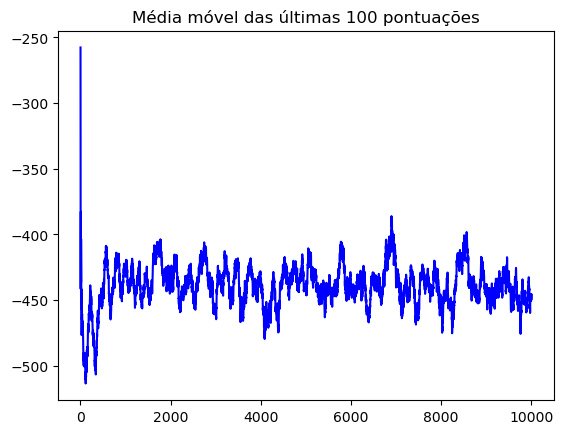

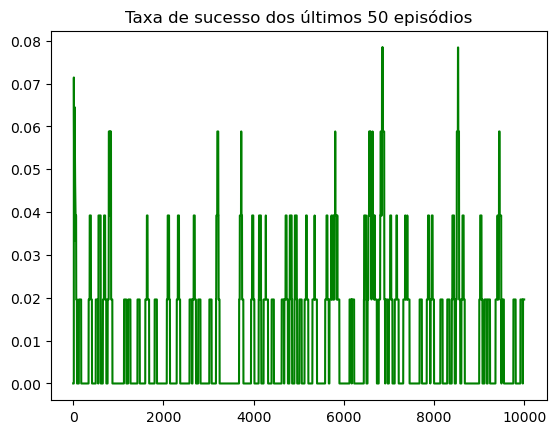

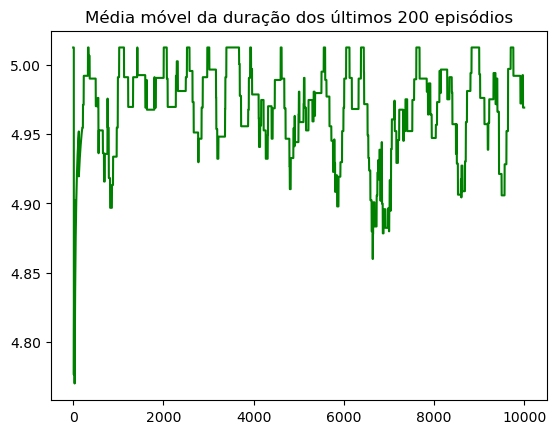

In [14]:
def main():
    plt.ion()
    env = MujocoEnv2_0()
    state_dim = env.state_dim
    action_dim = env.action_dim
    agent = Agent(state_dim, action_dim)

    load = input("load from model? [y/n]: ")
    
    filename = 'DDQN_mujoco'
    figure_file_score = 'plots/' + filename + '_score.png'
    figure_file_catchrate = 'plots/' + filename + '_catchrate.png'
    figure_file_steps = 'plots/' + filename + '_steps.png'

    if load == "y":
        agent.main_model = load_model(agent.main_model, MODEL_FILE)
        agent.target_model = load_model(agent.main_model, MODEL_FILE)
        actions = load_actions(MODEL_FILE+'_actions')
        agent.eps = agent.eps_min

    max_score = -10000
    max_game = 0
    scores = []
    start = datetime.datetime.now()
    
    step_history = []
    score_history = []
    success_history = []

    for game in range(N_GAMES):
        done = False
        score = 0
        success = 0
        observation = env.reset()
        #print(observation)
        game_actions = [] # actions taken during this game
        episode_start = datetime.datetime.now()

        if game%500 != 499:
            while not done:
                action = agent.choose_action(observation)
                next_observation, reward, done = env.step(action)
                action = torch.tensor(action).long()
                agent.step(observation, action, reward, next_observation, done)
                score += float(reward)
                observation = next_observation
                if reward > 0: success = 1
        else:
            while not done:
                action = agent.choose_action(observation)
                observation_, reward, done = env.rstep(action)
                action = torch.tensor(action).long()
                agent.step(observation, action, reward, next_observation, done)
                score += float(reward)
                observation = next_observation
                if reward > 0: success = 1
            media.show_video(env.frames, fps=env.framerate)

        if game % TARGET_UPDATE == 0: agent.soft_update_target_model(TAU)


        # Update variables each game
        agent.decrement_epsilon()
        episode_end = datetime.datetime.now()
        elapsed = episode_end - episode_start
        scores.append(score)
        avg_score = np.mean(scores[-100:])
        
        step_history.append(env.tfin)
        score_history.append(score)
        success_history.append(success)

        # Checks if the max score has been beaten
        if score > max_score:
            max_score = score
            max_game = game

            save_model(agent.main_model, MODEL_FILE)
            store_actions(game_actions, MODEL_FILE+'_actions')

        print("eps:",agent.eps)
        print('game:', game)
        print('steps',env.tfin)
        print('reward:', str(score))
        print("max reward:", str(max_score), "at game", str(max_game))
        print('average score for the last 100 games:', avg_score)
        print('time:', str(elapsed.total_seconds()),'seconds')
        print()

    # After going through N_GAMES
    end = datetime.datetime.now()
    elapsed = end - start

    print('Total time:',elapsed.total_seconds(), 'seconds')
    
    x = [i+1 for i in range(N_GAMES)]
    %matplotlib inline
    plt.figure('learning')
    plot_learning_curve(x, score_history, figure_file_score)
    plt.figure('catching')
    plot_success_curve(x, success_history, figure_file_catchrate)
    plt.figure('steps')
    plot_step_curve(x, step_history, figure_file_steps)

    scores_file = open(MODEL_FILE+'_scores','wb')
    pickle.dump(scores, scores_file)
    scores_file.close()

main()

In [ ]:
   ### RECOMPENSA DINÂMICA ###

# Hyperparameters
N_GAMES = 30001
MEM_SIZE = 100000
BATCH_SIZE = 32
TARGET_UPDATE = 4
GAMMA = 0.99
TAU = 0.005
LR = 1e-4
update_steps = 1
beta_start = 0.3
beta = 0.3
beta_frames = 30000

steps_taken = 0

if __name__ == '__main__':
    plt.ion()
    env = MujocoEnv2_1()
    state_dim = env.state_dim
    action_dim = env.action_dim
    agent = Agent(state_dim, action_dim)

    load = input("load from model? [y/n]: ")
    
    filename = 'DDQN_mujoco'
    figure_file_score = 'plots/' + filename + '_score.png'
    figure_file_catchrate = 'plots/' + filename + '_catchrate.png'
    figure_file_steps = 'plots/' + filename + '_steps.png'

    if load == "y":
        agent.main_model = load_model(agent.main_model, MODEL_FILE)
        agent.target_model = load_model(agent.main_model, MODEL_FILE)
        actions = load_actions(MODEL_FILE+'_actions')
        agent.eps = agent.eps_min

    max_score = -10000
    max_game = 0
    scores = []
    start = datetime.datetime.now()

    step_history = []
    score_history = []
    success_history = []
    partial_success_history = []
    next_level_points = []
    observable_games = [i for i in range(0, 30001, 500)]

    for game in range(N_GAMES):
        done = False
        score = 0
        success = 0
        observation = env.reset()
        #print(observation)
        game_actions = [] # actions taken during this game
        episode_start = datetime.datetime.now()
        step = 0

        if game not in observable_games:
            while not done:
                step += 1
                action = agent.choose_action(observation)
                next_observation, reward, done = env.step(action)
                action = torch.tensor(action).long()
                agent.step(observation, action, reward, next_observation, done)
                score += float(reward)
                if step % update_steps == 0 and len(agent.memory.buffer) > BATCH_SIZE:
                    beta = beta_start + (1.0 - beta_start) * min(1, game / beta_frames)
                    agent.learn(beta)
                observation = next_observation
                if reward > 0: success = 1
        else:
            while not done:
                step += 1
                action = agent.choose_action(observation)
                next_observation, reward, done = env.rstep(action)
                action = torch.tensor(action).long()
                agent.step(observation, action, reward, next_observation, done)
                score += float(reward)
                if step % update_steps == 0 and len(agent.memory.buffer) > BATCH_SIZE:
                    beta = beta_start + (1.0 - beta_start) * min(1, game / beta_frames)
                    agent.learn(beta)
                observation = next_observation
                if reward > 0: success = 1
            media.show_video(env.frames, fps=env.framerate)

        if game % TARGET_UPDATE == 0: agent.soft_update_target_model(TAU)

        # Update variables each game
        agent.decrement_epsilon()
        episode_end = datetime.datetime.now()
        elapsed = episode_end - episode_start
        scores.append(score)
        avg_score = np.mean(scores[-100:])
        
        step_history.append(env.tfin)
        score_history.append(score)
        success_history.append(success)
        partial_success_history.append(success)

        # Checks if the max score has been beaten
        if score > max_score:
            max_score = score
            max_game = game

            save_model(agent.main_model, MODEL_FILE)
            store_actions(game_actions, MODEL_FILE+'_actions')

        if len(partial_success_history)>600 and np.mean(partial_success_history[-100:])>0.9:
            partial_success_history = []
            env.setNextDistancia()
            agent.eps += 0.5
            next_level_points.append(game)
            max_score = -10000
            print('NEXT LEVEL')

        print("eps:",agent.eps)
        print('game:', game)
        print('reward:', str(score))
        print('average score for the last 100 games:', avg_score)
        print('partial success avg %.2f' %np.mean(partial_success_history[-100:]), ' dist %.2f' %env.dist)
        print('time:', str(elapsed.total_seconds()),'seconds')
        print('beta:', beta)
        print()

    # After going through N_GAMES
    end = datetime.datetime.now()
    elapsed = end - start

    print('Total time:',elapsed.total_seconds(), 'seconds')
    
    x = [i+1 for i in range(N_GAMES)]
    %matplotlib inline
    plt.figure('learning')
    plot_learning_curve(x, score_history, figure_file_score)
    plt.figure('catching')
    plot_success_curve(x, success_history, figure_file_catchrate)
    plt.figure('steps')
    plot_step_curve(x, step_history, figure_file_steps)

    scores_file = open(MODEL_FILE+'_scores','wb')
    pickle.dump(scores, scores_file)
    scores_file.close()

In [ ]:
'''
PER COM BUFFER
2*acao
512:256
self.e = 0.001  # Avoids priority 0
self.alpha = 0.6 # Priority control
self.beta = 0.3 # bias compensation
self.beta_increment = 0.00001
N_GAMES = 30001
MEM_SIZE = 100000
BATCH_SIZE = 32
TARGET_UPDATE = 8
GAMMA = 0.99
TAU = 0.005
LR = 1e-4
'''

In [ ]:
def plot_learning_curve(x, scores, figure_file):
    running_avg_score = np.zeros(len(scores))
    for i in range(len(running_avg_score)):
        running_avg_score[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg_score, '-b')
    plt.ylim(-300,200)
    plt.xticks(fontsize='15')
    plt.yticks(fontsize='15')
    plt.xlabel('Episódios',fontsize='18')
    plt.ylabel('Pontuação',fontsize='18')
    plt.axvline(x=next_level_points[-3], color='red')
    plt.axvline(0,color='red',linestyle='--')
    plt.text(-300,-200,'d = 0.45 m',rotation=-90,color='red',weight='bold',size='12')
    d = 0.45
    for p in next_level_points[:]:
        d = d*0.8
        plt.text(p+50,-200,'%.2f m'%d,rotation=-90,color='red',weight='bold',size='12')
        plt.axvline(x=p, color='red', linestyle='--')
    plt.title('Média móvel das últimas 100 pontuações',size='20',weight='bold')
    plt.savefig(figure_file)

def plot_success_curve(x, successes, figure_file):
    running_success_rate = np.zeros(len(successes))
    for i in range(len(running_success_rate)):
        running_success_rate[i] = np.mean(successes[max(0, i-50):(i+1)])
    plt.plot(x, running_success_rate, '-g')
    plt.xticks(fontsize='15')
    plt.yticks(fontsize='15')
    plt.xlabel('Episódios',fontsize='18')
    plt.ylabel('Taxa de sucesso',fontsize='18')
    plt.axvline(x=next_level_points[-3], color='red')
    plt.axvline(0,color='red',linestyle='--')
    plt.text(65,0.12,'d = 0.45 m',rotation=-90,color='red',weight='bold',size='12')
    d = 0.45
    for p in next_level_points[:]:
        d = d*0.8
        plt.text(p+50,0.12,'%.2f m'%d,rotation=-90,color='red',weight='bold',size='12')
        plt.axvline(x=p, color='red', linestyle='--')
    plt.title('Taxa de sucesso dos últimos 50 episódios',size='20',weight='bold')
    plt.savefig(figure_file)

def plot_step_curve(x, steps, figure_file):
    running_step_avg = np.zeros(len(steps))
    for i in range(len(running_step_avg)):
        running_step_avg[i] = np.mean(steps[max(0, i-200):(i+1)])
    plt.plot(x, running_step_avg, '-g')
    plt.xticks(fontsize='15')
    plt.yticks(fontsize='15')
    plt.xlabel('Episódios',fontsize='18')
    plt.ylabel('Tempo até atingir o alvo (s)',fontsize='18')
    plt.axvline(x=next_level_points[-3], color='red')
    plt.axvline(0,color='red',linestyle='--')
    plt.text(65,4,'d = 0.45 m',rotation=-90,color='red',weight='bold',size='12')
    d = 0.45
    for p in next_level_points[:]:
        d = d*0.8
        plt.text(p+50,4,'%.2f m'%d,rotation=-90,color='red',weight='bold',size='12')
        plt.axvline(x=p, color='red', linestyle='--')
    plt.title('Média móvel da duração dos últimos 200 episódios',size='20',weight='bold')
    plt.savefig(figure_file)

x = [i+1 for i in range(30001)]
%matplotlib inline
plt.figure('learning',figsize=(15,6))
plot_learning_curve(x, score_history, figure_file_score)
plt.figure('catching',figsize=(15,6))
plot_success_curve(x, success_history, figure_file_catchrate)
plt.figure('steps',figsize=(15,6))
plot_step_curve(x, step_history, figure_file_steps)

In [ ]:
save_model(agent.main_model, MODEL_FILE)
store_actions(game_actions, MODEL_FILE+'_actions')

In [ ]:
plt.ion()
env = MujocoEnv2_1()
state_dim = env.state_dim
action_dim = env.action_dim
agent = Agent(state_dim, action_dim)

agent.main_model = load_model(agent.main_model, MODEL_FILE)
agent.target_model = load_model(agent.main_model, MODEL_FILE)
actions = load_actions(MODEL_FILE+'_actions')
agent.eps = agent.eps_min

fixedGames = []
for i in np.arange(1, 1.5, 0.1):
    for j in np.arange(0, 2*np.pi, np.pi/18):
        list = [i, j] 
        fixedGames.append(list)

for game in range(len(fixedGames)):
    env.variaPos(float(fixedGames[game][0]),float(fixedGames[game][1]))
    done = False
    score = 0
    success = 0
    observation = env.resetFixo()
    game_actions = [] # actions taken during this game

    while not done:
        action = agent.choose_action(observation)
        next_observation, reward, done = env.rstep(action)
        action = torch.tensor(action).long()
        #agent.step(observation, action, reward, next_observation, done)
        score += float(reward)
        observation = next_observation
        #if game % TARGET_UPDATE == 0: agent.soft_update_target_model(TAU)
        if reward > 0: success = 1
    media.show_video(env.frames, fps=env.framerate)

    print('Jogo:', game, ' \  Raio:', env.radius, ' \  Ângulo:', env.angle*180/np.pi)
    print('Recompensa:', str(score))
    print('-------------------------------------------------')
